https://github.com/madsenmj/python_arima/blob/master/IntroductionToTimeSeries.ipynb

1. Extracting data from a public API
2. Exploring the data in a Jupyter notebook
3. Building an ARIMA time-series forecast model for the data
4. Evaluating the model

In [51]:
# This package is not in the base Anaconda package list
try:
    import pmdarima
except:
    !pip install pmdarima
    
# import and setup
import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 1000)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import json, requests, getpass, datetime, warnings
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

def print_wrapped(data, ncols=3):
    """A helper function to wrap data columns for easier viewing"""
    nrows = len(data)
    labels = data.index
    n_split_rows = int(np.ceil(nrows/ncols))
    for r in range(0,nrows,ncols):
        for c in range(ncols):
            try:
                numstr = '{ }' .format(data(r+c))
                tabs = [' ']*(20-len(labels[r+c])-len(numstr))
                print(labels[r+c]+" ".join(tabs)+numstr, end='\t')
            except:
                      pass
        print()

### Data Extraction

In [8]:
url = 'https://data.iowa.gov/resource/spsw-4jax.json'
options = '?$select=date,county,sum(sale_dollars),sum(sale_liters)&$group=date,county&$limit=10&$offset=1500'
myResponse = requests.get(url + options, verify=True)
print(myResponse.content.decode('utf-8'))

[{"date":"2012-11-13T00:00:00.000","county":"Muscatine","sum_sale_dollars":"44546.24","sum_sale_liters":"3339.80"}
,{"date":"2017-12-29T00:00:00.000","county":"PAGE","sum_sale_dollars":"21786.92","sum_sale_liters":"1317.16"}
,{"date":"2013-03-19T00:00:00.000","county":"Kossuth","sum_sale_dollars":"6356.38","sum_sale_liters":"451.47"}
,{"date":"2015-05-13T00:00:00.000","county":"Wapello","sum_sale_dollars":"39971.14","sum_sale_liters":"2975.28"}
,{"date":"2013-02-12T00:00:00.000","county":"Winnebago","sum_sale_dollars":"1138.92","sum_sale_liters":"125.70"}
,{"date":"2018-03-23T00:00:00.000","county":"FAYETTE","sum_sale_dollars":"18542.65","sum_sale_liters":"1391.33"}
,{"date":"2018-01-18T00:00:00.000","county":"MARSHALL","sum_sale_dollars":"42702.81","sum_sale_liters":"2922.67"}
,{"date":"2015-08-10T00:00:00.000","county":"Clinton","sum_sale_dollars":"3565.14","sum_sale_liters":"220.33"}
,{"date":"2018-06-28T00:00:00.000","county":"CRAWFORD","sum_sale_dollars":"33950.59","sum_sale_liter

In [9]:
def getCityDailyData(offset=0):
    """
    A function to pull the sales by county from the Iowa public database.
    
    Args:
        offset (optional, default 0): An offset to the records (if there are more than 50,000)
        
    Returns:
        A JSON array with the results.
        
    """
    
    url = 'https://data.iowa.gov/resource/spsw-4jax.json'
    selectQuery = '?$select=date,county,sum(sale_dollars),sum(sale_liters)&$group=date,county'

    limitQuery = '&$limit=50000'
    if (offset > 0):
        offset = '&$offset={}'.format(offset)
        query = url + selectQuery + limitQuery + offset
    else:
        query = url + selectQuery + limitQuery

    # Send the query to the API endpoint
    myResponse = requests.get(query, verify=True)

    jData=''
    # For successful API call, response code will be 200 (OK)
        
    try:
        if(myResponse.ok):
            jData = json.loads(myResponse.content.decode('utf-8'))
            print("The response contains {0} properties".format(len(jData)))
        else:
            print(myResponse.status_code)
            print(myResponse.headers)
            
    except:
        print(myResponse.status_code)
        print(myResponse.headers)
        
        
    return jData

In [10]:
data_set1 = getCityDailyData()

The response contains 50000 properties


In [11]:
data_set2 = getCityDailyData(50000)

The response contains 23456 properties


In [12]:
ildfs = pd.io.json.json_normalize(data_set1)
ildfs2 = pd.io.json.json_normalize(data_set2)
df = ildfs.append(ildfs2)

df.head()

D:\Anaconda3\envs\arima\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.
D:\Anaconda3\envs\arima\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,date,county,sum_sale_dollars,sum_sale_liters
0,2012-02-14T00:00:00.000,Buchanan,786.29,68.50
1,2012-12-26T00:00:00.000,Hamilton,18397.00,1307.71
2,2016-08-22T00:00:00.000,Marion,1132.09,100.12
3,2016-02-01T00:00:00.000,Clinton,1662.50,106.34
4,2013-08-27T00:00:00.000,Wright,15639.14,1239.00


In [13]:
df

,date,county,sum_sale_dollars,sum_sale_liters
0,2012-02-14T00:00:00.000,Buchanan,786.29,68.50
1,2012-12-26T00:00:00.000,Hamilton,18397.00,1307.71
2,2016-08-22T00:00:00.000,Marion,1132.09,100.12
3,2016-02-01T00:00:00.000,Clinton,1662.50,106.34
4,2013-08-27T00:00:00.000,Wright,15639.14,1239.00
...,...,...,...,...
23451,2015-05-21T00:00:00.000,Polk,413537.78,25578.88
23452,2014-08-27T00:00:00.000,Scott,202228.51,15639.17
23453,2016-09-03T00:00:00.000,BUTLER,1949.63,159.60
23454,2013-02-04T00:00:00.000,Black Hawk,146356.19,11239.95


In [14]:
df.to_csv('raw_iowa_data.csv', index=False)

### Data Exploration

In [15]:
df = pd.read_csv('raw_iowa_data.csv')
df.dtypes

date                 object
county               object
sum_sale_dollars    float64
sum_sale_liters     float64
dtype: object

In [16]:
df['date'] = pd.to_datetime(df['date'])
print(df.dtypes)
df.head()

date                datetime64[ns]
county                      object
sum_sale_dollars           float64
sum_sale_liters            float64
dtype: object


,date,county,sum_sale_dollars,sum_sale_liters
0,2012-02-14,Buchanan,786.29,68.50
1,2012-12-26,Hamilton,18397.00,1307.71
2,2016-08-22,Marion,1132.09,100.12
3,2016-02-01,Clinton,1662.50,106.34
4,2013-08-27,Wright,15639.14,1239.00


In [17]:
current_month = datetime.datetime.now().strftime('%Y-%m-01')
print("Initial last date: {}".format(df['date'].max()))

# Filter rows using the date column
df = df[df['date'] < current_month]
print("After filter last date: {}".format(df['date'].max()))

Initial last date: 2020-02-28 00:00:00
After filter last date: 2020-02-28 00:00:00


In [18]:
county_rows = df.groupby('county').date.count()
print_wrapped(county_rows, ncols=4)

In [19]:
df['county'] = df['county'].str.upper()
df.dropna(inplace=True)

df.loc[df['county'] == 'BUENA VIST','county'] = 'BUENA VISTA'
df.loc[df['county'] == 'CERRO GORD','county'] = 'CERRO GORDO'
df.loc[df['county'] == 'OBRIEN','county'] = "O'BRIEN"
df.loc[df['county'] == 'POTTAWATTA','county'] = "POTTAWATTAMIE"
df = df.loc[df['county'] != 'EL PASO']

col_v2 = df.groupby('county').date.count()
print_wrapped(col_v2, ncols=4)

In [20]:

df['month'] = df['date'].apply(lambda x: x.strftime('%Y-%m-01'))
df['month'] = pd.to_datetime(df['month'])
df.head()

,date,county,sum_sale_dollars,sum_sale_liters,month
0,2012-02-14,BUCHANAN,786.29,68.50,2012-02-01
1,2012-12-26,HAMILTON,18397.00,1307.71,2012-12-01
2,2016-08-22,MARION,1132.09,100.12,2016-08-01
3,2016-02-01,CLINTON,1662.50,106.34,2016-02-01
4,2013-08-27,WRIGHT,15639.14,1239.00,2013-08-01


### Visualizing Data

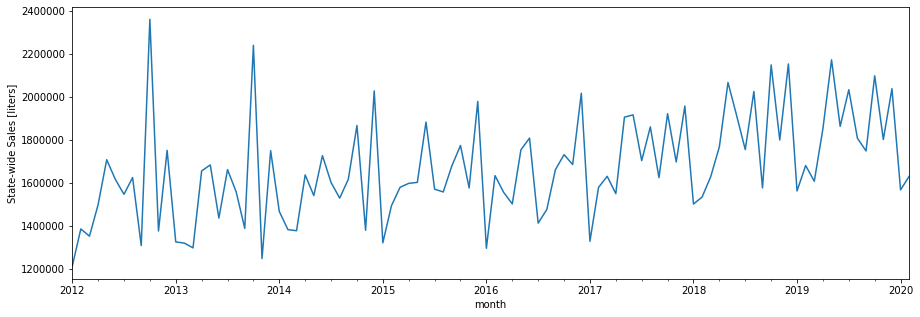

In [21]:
state_data = df.groupby('month').sum()
state_data['sum_sale_liters'].plot(figsize=[15,5])
plt.ylabel('State-wide Sales [liters]')
plt.show()

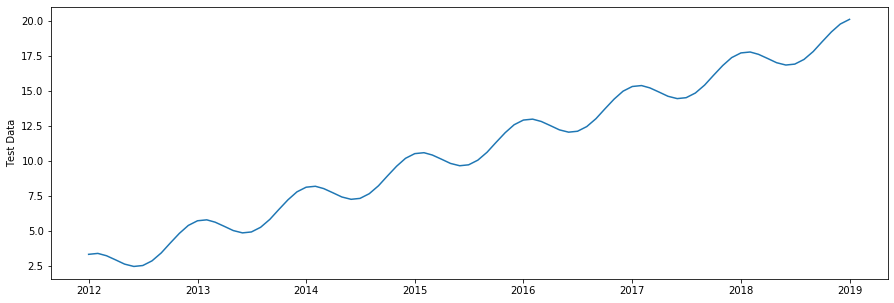

In [22]:
x = np.arange('2012-01', '2019-02', dtype='datetime64[M]')
xm = (x - np.min(x)).astype('int')
y = 2.3 + 0.2 * xm + np.cos(2 * np.pi * xm / 12)
fig, ax = plt.subplots(figsize=[15,5])
ax.plot(x,y)
ax.set_ylabel("Test Data")
plt.show()

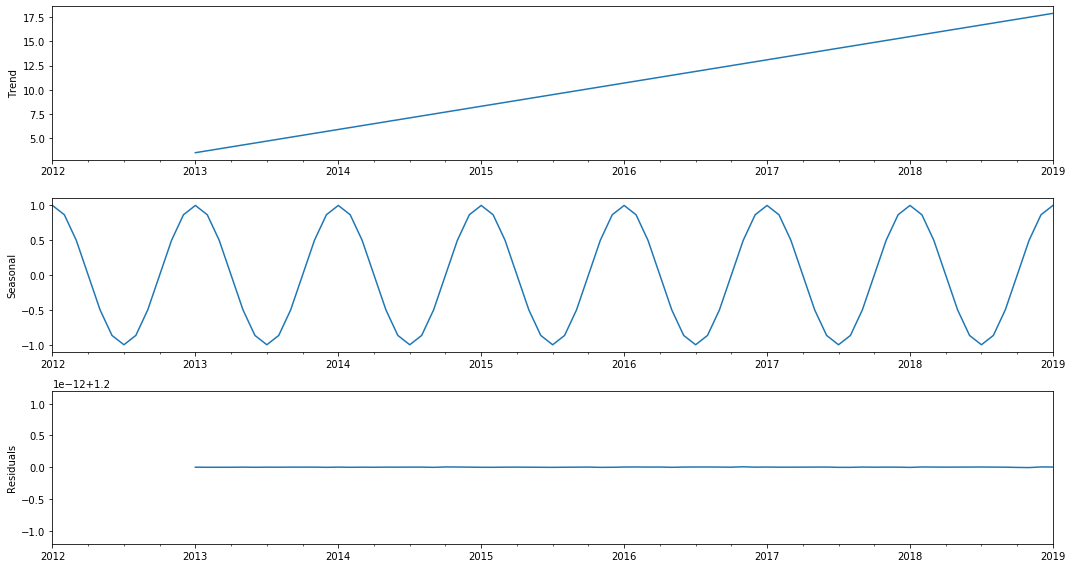

In [23]:
xy = pd.DataFrame(y,x, columns=['y'])
res = seasonal_decompose(xy, model='additive', two_sided=False)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1)
ax1.set_ylabel('Trend')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.resid.plot(ax=ax3)
ax3.set_ylabel('Residuals')
plt.tight_layout()

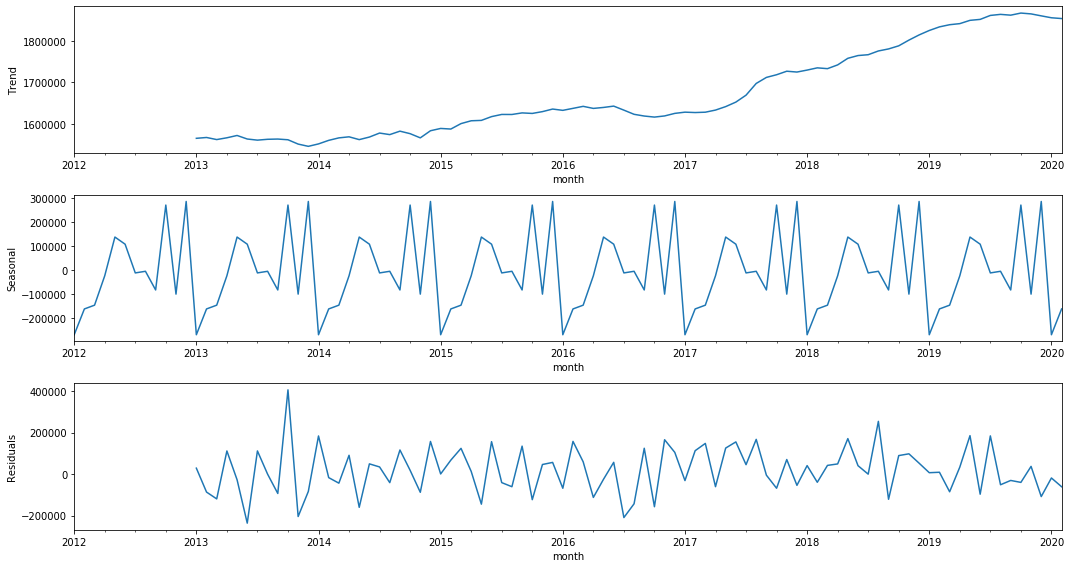

In [24]:

res = seasonal_decompose(state_data['sum_sale_liters'], model='additive', two_sided=False)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1)
ax1.set_ylabel('Trend')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.resid.plot(ax=ax3)
ax3.set_ylabel('Residuals')
plt.tight_layout()

### Forecasting Total Liters Sold

I start with a simple, single time cut. I use 2017-06-01 as the time cut -- that gives me about 66 months of training data and 18 months of test data.

My next step is to get a baseline model - the easiest model I can think of to compare against. In this case, I think that the simple "use last year's number" is a reasonable first step.

In [25]:
state_data_train = state_data[state_data.index <= '2017-06-01']
state_data_test = state_data[state_data.index > '2017-06-01']

# Get the dates from the test data
test_months = state_data_test.reset_index(drop=False)['month']

# Offset them by a year
previous_year = test_months.apply(lambda x: x - relativedelta(years=1))

# Get the values from the previous year
last_year_preds = state_data.loc[previous_year, 'sum_sale_liters'].values

In [34]:
state_data_train.head()

,sum_sale_dollars,sum_sale_liters
month,,
2012-01-01,15897273.61,1210432.99
2012-02-01,18099551.75,1385076.03
2012-03-01,18120872.90,1351362.75
2012-04-01,19981105.52,1497612.53
2012-05-01,22168563.29,1707345.64


In [30]:
state_data_test.head()

,sum_sale_dollars,sum_sale_liters
month,,
2017-07-01,24693774.93,1703210.78
2017-08-01,27057181.12,1860168.84
2017-09-01,24080303.80,1623967.63
2017-10-01,30199858.09,1921716.42
2017-11-01,26445293.51,1697029.89


In [29]:
test_months.head()

0   2017-07-01
1   2017-08-01
2   2017-09-01
3   2017-10-01
4   2017-11-01
Name: month, dtype: datetime64[ns]

In [35]:
test_months.tail()

27   2019-10-01
28   2019-11-01
29   2019-12-01
30   2020-01-01
31   2020-02-01
Name: month, dtype: datetime64[ns]

In [32]:
previous_year

0    2016-07-01
1    2016-08-01
2    2016-09-01
3    2016-10-01
4    2016-11-01
5    2016-12-01
6    2017-01-01
7    2017-02-01
8    2017-03-01
9    2017-04-01
10   2017-05-01
11   2017-06-01
12   2017-07-01
13   2017-08-01
14   2017-09-01
15   2017-10-01
16   2017-11-01
17   2017-12-01
18   2018-01-01
19   2018-02-01
20   2018-03-01
21   2018-04-01
22   2018-05-01
23   2018-06-01
24   2018-07-01
25   2018-08-01
26   2018-09-01
27   2018-10-01
28   2018-11-01
29   2018-12-01
30   2019-01-01
31   2019-02-01
Name: month, dtype: datetime64[ns]

In [33]:
last_year_preds

array([1412127.41, 1475350.29, 1661034.76, 1730854.62, 1685031.57,
       2016906.66, 1327711.31, 1578500.94, 1630136.59, 1549313.61,
       1905452.  , 1916214.67, 1703210.78, 1860168.84, 1623967.63,
       1921716.42, 1697029.89, 1957198.33, 1500975.99, 1533529.55,
       1628794.23, 1767516.36, 2067055.67, 1913298.38, 1754582.12,
       2025030.6 , 1576146.33, 2148657.36, 1799249.15, 2153293.63,
       1561846.4 , 1680273.91])

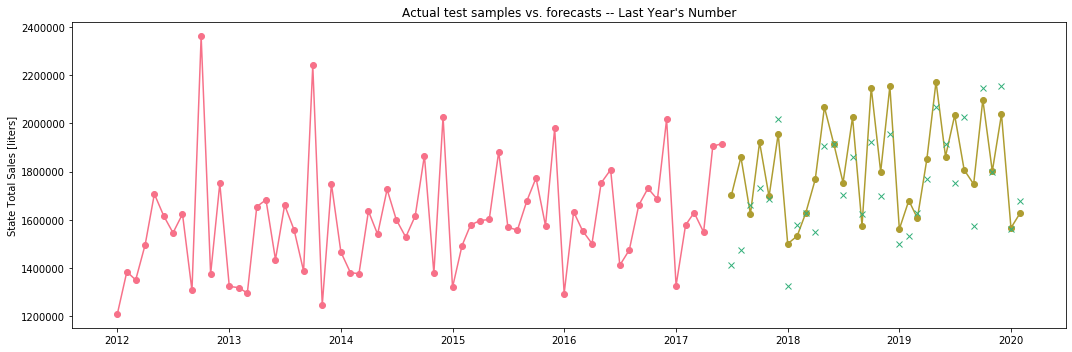

In [36]:
fig_1, ax = plt.subplots( figsize=(15,5))
clrs = sns.color_palette("husl", 5)

# #############################################################################
# Plot actual test vs. forecasts:
plt.plot(state_data_train.index, state_data_train['sum_sale_liters'], marker='o', c=clrs[0])

plt.plot(state_data_test.index, state_data_test['sum_sale_liters'], marker='o', c=clrs[1])

plt.plot(state_data_test.index, last_year_preds, linestyle='None', marker='x', c=clrs[2])

plt.title("Actual test samples vs. forecasts -- Last Year's Number")
plt.ylabel('State Total Sales [liters]')
plt.tight_layout()
plt.close()
fig_1

In [37]:
# Fit a simple auto_arima model
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    state_arima = auto_arima(state_data_train['sum_sale_liters'], 
                                 error_action='ignore', 
                                 trace=True,
                                 seasonal=True, 
                                 m=12)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(1, 0, 1, 12) (constant=True); AIC=1813.509, BIC=1830.904, Time=0.282 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=True); AIC=1851.400, BIC=1855.749, Time=0.012 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 12) (constant=True); AIC=1809.490, BIC=1818.188, Time=0.047 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 12) (constant=True); AIC=1811.124, BIC=1819.821, Time=0.061 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=False); AIC=1849.467, BIC=1851.641, Time=0.007 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 12) (constant=True); AIC=1823.090, BIC=1829.613, Time=0.016 seconds
Fit ARIMA: (1, 1, 0)x(2, 0, 0, 12) (constant=True); AIC=1810.946, BIC=1821.818, Time=0.120 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 1, 12) (constant=True); AIC=1811.224, BIC=1822.096, Time=0.053 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 1, 12) (constant=True); AIC=1812.022, BIC=1820.719, Time=0.041 seconds
Fit ARIMA: (1, 1, 0)x(2, 0, 1, 12) (constant=True); AIC=1811.179,

In [38]:
state_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   66
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -898.831
Date:                            Sun, 22 Mar 2020   AIC                           1807.663
Time:                                    18:26:19   BIC                           1818.534
Sample:                                         0   HQIC                          1811.952
                                             - 66                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.851e+04   3.28e+04      0.565      0.572   -4.57e+04    8.27e+04
ar.L1         -0.6565      0.098     -6.665      0.000      -0.850      -0.463
ar.L2         -0.2620      0.103     -2.548      0.011      -0.464      -0.060
ar.S.L12       0.4945      0.085      5.846      0.000       0.329       0.660
sigma2      6.095e+10      0.032   1.93e+12      0.000     6.1e+10     6.1e+10
===================================================================================
Ljung-Box (Q):                       34.21   Jarque-Bera (JB):                18.08
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.18e+27. Standard errors may be unstable.
"""

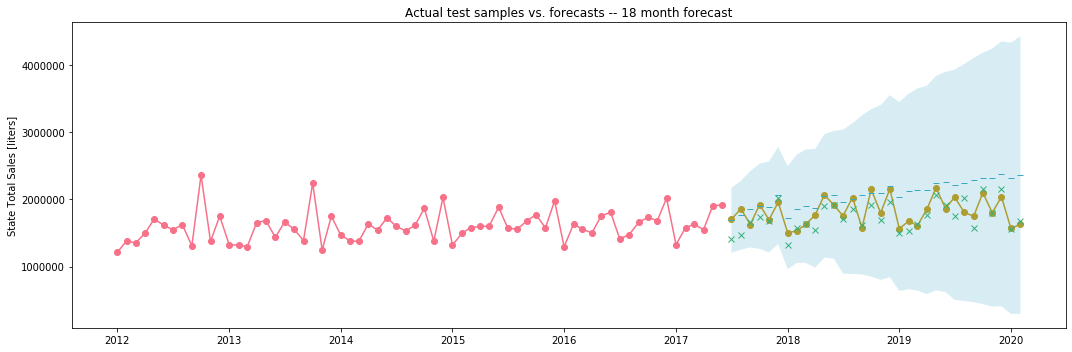

In [39]:
predictions = state_arima.predict(n_periods=state_data_test.shape[0], return_conf_int=True)
pred_mean = predictions[0]
pred_interval = predictions[1]

fig_1, ax = plt.subplots( figsize=(15,5))
clrs = sns.color_palette("husl", 5)

# #############################################################################
# Plot actual test vs. forecasts:
plt.plot(state_data_train.index, state_data_train['sum_sale_liters'], marker='o', c=clrs[0])

plt.plot(state_data_test.index, state_data_test['sum_sale_liters'], marker='o', c=clrs[1])

plt.plot(state_data_test.index, last_year_preds, linestyle='None', marker='x', c=clrs[2])

plt.plot(state_data_test.index, pred_mean, linestyle='None', marker='_', c=clrs[3])
plt.fill_between(state_data_test.index, pred_interval[:,0], pred_interval[:,1], alpha=0.2, facecolor=clrs[3])

plt.title('Actual test samples vs. forecasts -- 18 month forecast')
plt.ylabel('State Total Sales [liters]')
plt.tight_layout()
plt.close()
fig_1

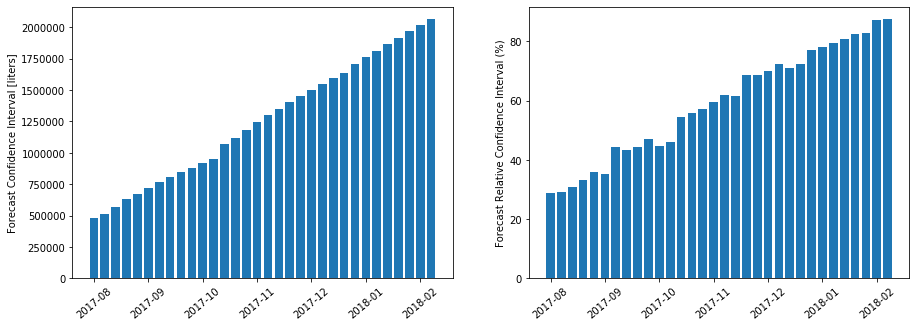

In [40]:
fig_1, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
ax1.bar(range(len(state_data_test.index)), (pred_interval[:,1] - pred_mean))
ax1.set_xticklabels(state_data_test.index.strftime('%Y-%m'), rotation=40)
ax1.set_ylabel("Forecast Confidence Interval [liters]")

ax2.bar(range(len(state_data_test.index)), (pred_interval[:,1] - pred_mean)/(pred_mean)*100)
ax2.set_xticklabels(state_data_test.index.strftime('%Y-%m'), rotation=40)
ax2.set_ylabel("Forecast Relative Confidence Interval (%)")
plt.show()

In [41]:
start_date = datetime.datetime(2017,6,1)

r = relativedelta(state_data.index.max(), start_date)
n_months = r.months + r.years * 12 - 1

prediction_df = pd.DataFrame({'date':[],'actual':[],'pred':[],'pred_interval_low':[],'pred_interval_high':[]})

for months_from_start in range(n_months):
    current_split_month = (start_date + relativedelta(months=months_from_start)).strftime('%Y-%m-%d')
    
    
    state_data_train = state_data[state_data.index <= current_split_month]
    state_data_test = state_data[state_data.index > current_split_month]
    print("Splitting at {} with {} months in train and {} in test".format(current_split_month,
                                                                         len(state_data_train),
                                                                         len(state_data_test)))
    

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        state_arima = auto_arima(state_data_train['sum_sale_liters'], error_action='ignore', trace=False,
                          seasonal=True, m=12)
    
    predict_month = start_date + relativedelta(months=(months_from_start + 2))
    predictions = state_arima.predict(n_periods=2, return_conf_int=True)
    pred_mean = predictions[0][-1]
    pred_interval = predictions[1][-1]
    
    actual = state_data_test.loc[predict_month.strftime('%Y-%m-%d'),'sum_sale_liters']
    
    pred_interval_low = pred_interval[0]
    pred_interval_high = pred_interval[1]
    prediction_df = prediction_df.append({'date':predict_month,
                                          'actual':actual,
                                         'pred':pred_mean,
                                         'pred_interval_low':pred_interval_low,
                                         'pred_interval_high':pred_interval_high}, ignore_index=True)
    
prediction_df.set_index('date', inplace=True)

Splitting at 2017-06-01 with 66 months in train and 32 in test
Splitting at 2017-07-01 with 67 months in train and 31 in test
Splitting at 2017-08-01 with 68 months in train and 30 in test
Splitting at 2017-09-01 with 69 months in train and 29 in test
Splitting at 2017-10-01 with 70 months in train and 28 in test
Splitting at 2017-11-01 with 71 months in train and 27 in test
Splitting at 2017-12-01 with 72 months in train and 26 in test
Splitting at 2018-01-01 with 73 months in train and 25 in test
Splitting at 2018-02-01 with 74 months in train and 24 in test
Splitting at 2018-03-01 with 75 months in train and 23 in test
Splitting at 2018-04-01 with 76 months in train and 22 in test
Splitting at 2018-05-01 with 77 months in train and 21 in test
Splitting at 2018-06-01 with 78 months in train and 20 in test
Splitting at 2018-07-01 with 79 months in train and 19 in test
Splitting at 2018-08-01 with 80 months in train and 18 in test
Splitting at 2018-09-01 with 81 months in train and 17 

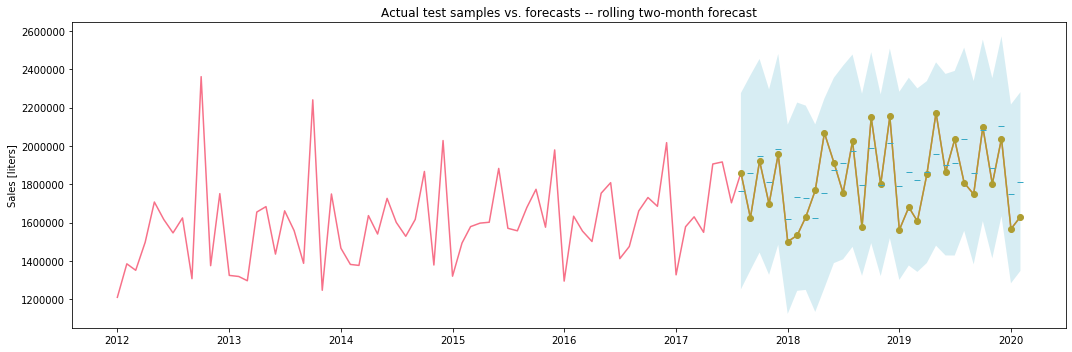

In [42]:
fig_2, ax = plt.subplots( figsize=(15,5))
clrs = sns.color_palette("husl", 5)

# #############################################################################
# Plot actual test vs. forecasts:
plt.plot(state_data.index, state_data['sum_sale_liters'], c=clrs[0])

plt.plot(prediction_df.index, prediction_df['actual'], marker='o', c=clrs[1])

plt.plot(prediction_df.index, prediction_df['pred'], marker='_', linestyle='None', c=clrs[3])
plt.fill_between(prediction_df.index, prediction_df['pred_interval_low'], prediction_df['pred_interval_high'], alpha=0.2, facecolor=clrs[3])

plt.title('Actual test samples vs. forecasts -- rolling two-month forecast')
plt.ylabel('Sales [liters]')
plt.tight_layout()
plt.close()
fig_2

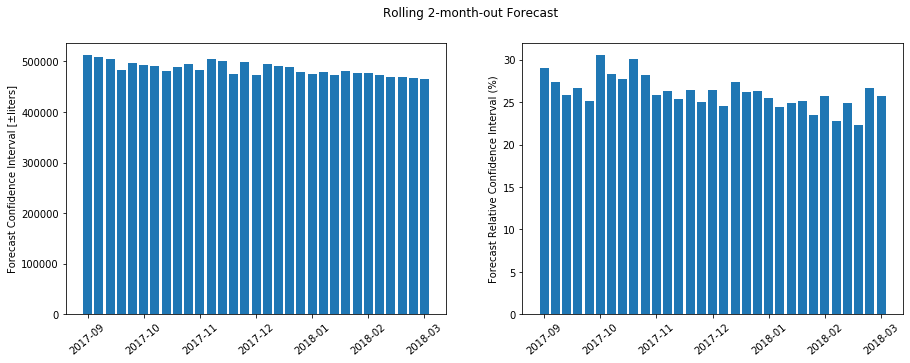

In [43]:
fig_1, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
ax1.bar(range(len(prediction_df.index)),
       (prediction_df['pred_interval_high'] - prediction_df['pred']))
ax1.set_xticklabels(prediction_df.index.strftime('%Y-%m'), rotation=40)
ax1.set_ylabel("Forecast Confidence Interval [±liters]")

ax2.bar(range(len(prediction_df.index)), 
        (prediction_df['pred_interval_high'] - prediction_df['pred'])/(prediction_df['pred'])*100)
ax2.set_xticklabels(prediction_df.index.strftime('%Y-%m'), rotation=40)
ax2.set_ylabel("Forecast Relative Confidence Interval (%)")
plt.suptitle("Rolling 2-month-out Forecast")
plt.show()

### County-level forecasts

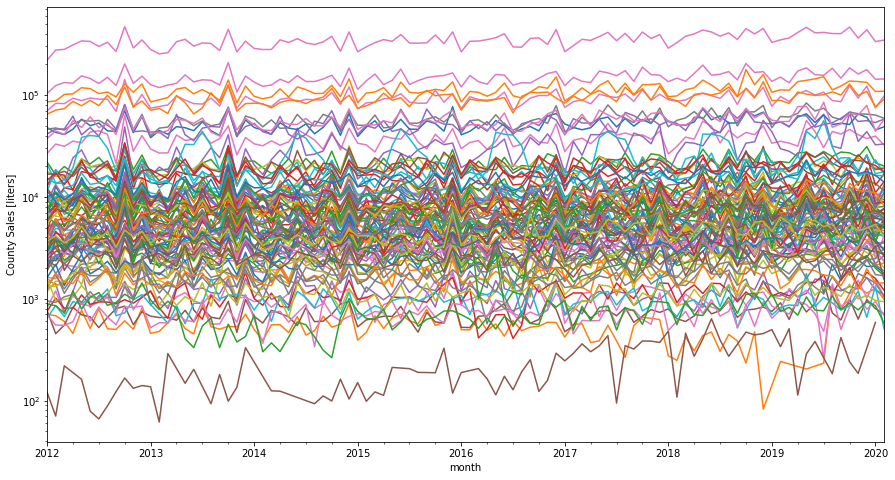

In [44]:

county_data = df.groupby(['month','county']).sum().reset_index(drop=False, level=1)

fig, ax = plt.subplots(figsize=[15,8])

for county in county_data['county'].unique():
    county_data.loc[county_data['county'] == county, 'sum_sale_liters'].plot(ax=ax, label=county)
    
ax.set_yscale("log", nonposy='clip')
ax.set_ylabel("County Sales [liters]")
plt.show()

In [45]:
df.groupby('county').sum().sort_values('sum_sale_liters', ascending=False).head()

,sum_sale_dollars,sum_sale_liters
county,,
POLK,5.438392e+08,34084952.01
LINN,2.106144e+08,14525757.87
SCOTT,1.724126e+08,11119660.45
JOHNSON,1.442417e+08,9104887.12
BLACK HAWK,1.369563e+08,9080240.09


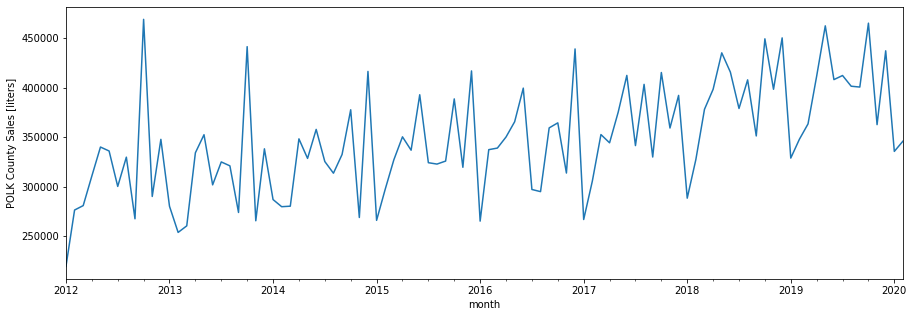

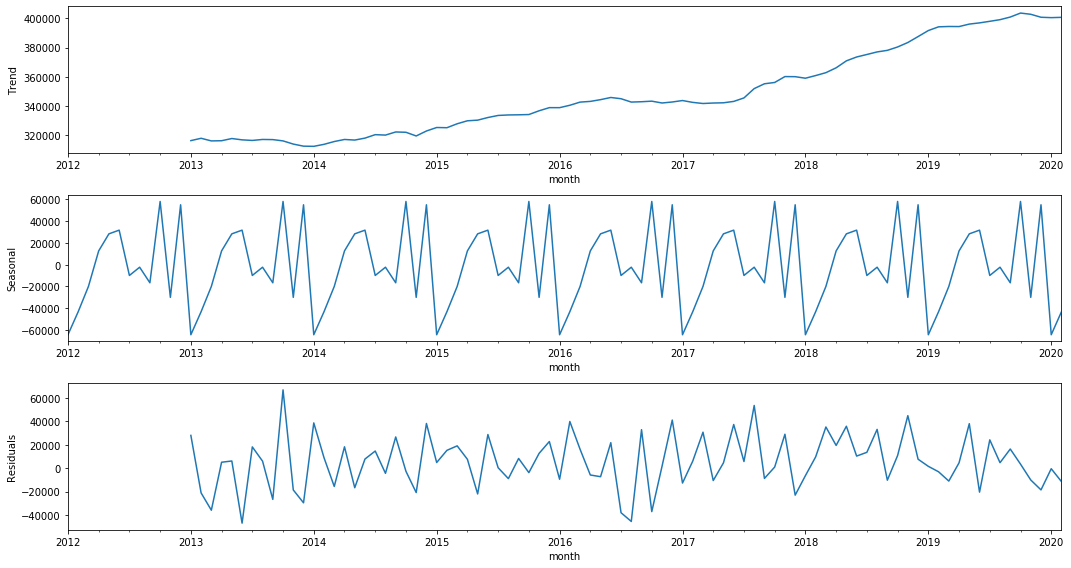

In [46]:
df_county = df[df['county'] == 'POLK'].groupby('month').sum()
df_county['sum_sale_liters'].plot(figsize=[15,5])
plt.ylabel("POLK County Sales [liters]")

res = seasonal_decompose(df_county['sum_sale_liters'], model='additive', two_sided=False)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1)
ax1.set_ylabel('Trend')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.resid.plot(ax=ax3)
ax3.set_ylabel('Residuals')
plt.tight_layout()

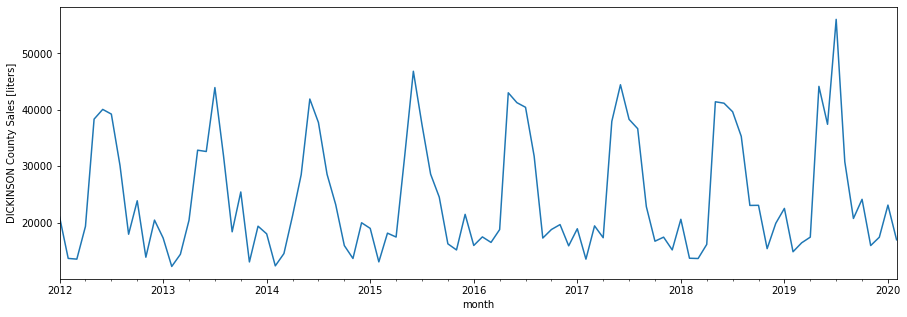

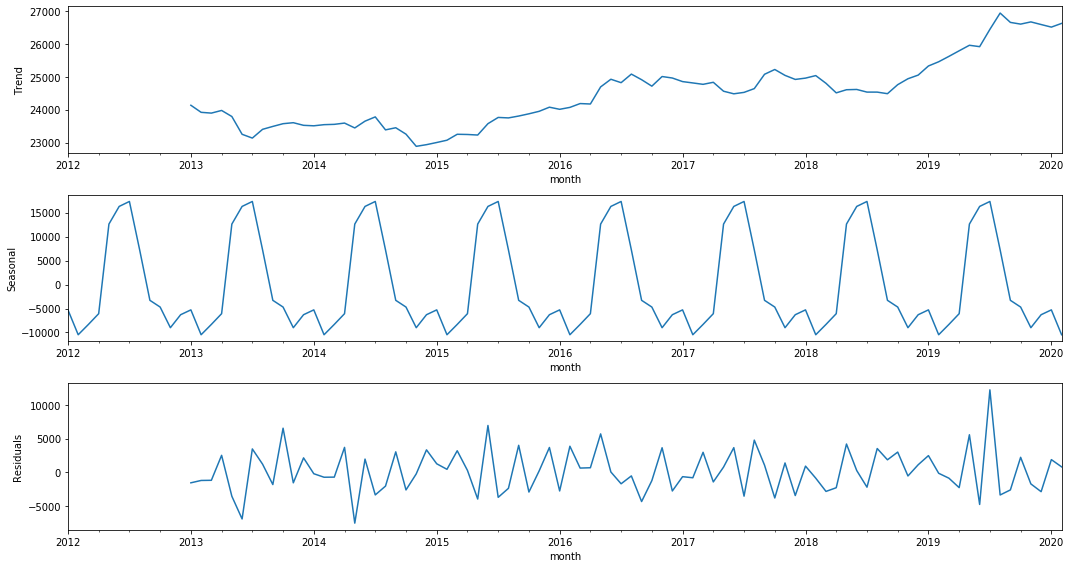

In [47]:
df_county = df[df['county'] == 'DICKINSON'].groupby('month').sum()
df_county['sum_sale_liters'].plot(figsize=[15,5])
plt.ylabel("DICKINSON County Sales [liters]")

res = seasonal_decompose(df_county['sum_sale_liters'], model='additive', two_sided=False)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1)
ax1.set_ylabel('Trend')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.resid.plot(ax=ax3)
ax3.set_ylabel('Residuals')
plt.tight_layout()

In [48]:
def forecast_county(df_county):
    """A function to create the rolling 2-month-out forecast"""
    
    start_date = datetime.datetime(2017,6,1)

    r = relativedelta(df_county.index.max(), start_date)
    n_months = r.months + r.years * 12 - 1

    prediction_county = pd.DataFrame({'date':[],'actual':[],'pred':[],'pred_interval_low':[],'pred_interval_high':[]})

    for months_from_start in range(n_months):
        current_split_month = (start_date + relativedelta(months=months_from_start)).strftime('%Y-%m-%d') 

        df_county_train = df_county[df_county.index <= current_split_month]
        df_county_test = df_county[df_county.index > current_split_month]
        print("Splitting at {} with {} months in train and {} in test".format(current_split_month,
                                                                             len(df_county_train),
                                                                             len(df_county_test)))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            dickinson_arima = auto_arima(df_county_train['sum_sale_liters'], error_action='ignore', trace=False,
                              seasonal=True, m=12)

        predict_month = start_date + relativedelta(months=(months_from_start + 2))
        predictions = dickinson_arima.predict(n_periods=2, return_conf_int=True)
        pred_mean = predictions[0][-1]
        pred_interval = predictions[1][-1]

        actual = df_county_test.loc[predict_month.strftime('%Y-%m-%d'),'sum_sale_liters']

        pred_interval_low = pred_interval[0]
        pred_interval_high = pred_interval[1]
        prediction_county = prediction_county.append({'date':predict_month,
                                              'actual':actual,
                                             'pred':pred_mean,
                                             'pred_interval_low':pred_interval_low,
                                             'pred_interval_high':pred_interval_high}, ignore_index=True)

    prediction_county.set_index('date', inplace=True)
    return prediction_county

In [49]:
def show_plots(df_county, prediction_county, county_name=""):
    """A function to plot the rolling 2-month-out forecast results"""
    
    fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(2, 2)
    ax1 = plt.subplot(gs[0, :])
    ax2 = plt.subplot(gs[1,0])
    ax3 = plt.subplot(gs[1,1])

    clrs = sns.color_palette("husl", 5)

    # #############################################################################
    # Plot actual test vs. forecasts:
    ax1.plot(df_county.index, df_county['sum_sale_liters'], c=clrs[0])

    ax1.plot(prediction_county.index, prediction_county['actual'], marker='o', c=clrs[1])

    ax1.plot(prediction_county.index, prediction_county['pred'], marker='_', linestyle='None', c=clrs[3])
    ax1.fill_between(prediction_county.index, prediction_county['pred_interval_low'], prediction_county['pred_interval_high'], alpha=0.2, facecolor=clrs[3])

    ax1.set_ylabel('{} County Sales [liters]'.format(county_name))

    ax2.bar(range(len(prediction_county.index)),
           (prediction_county['pred_interval_high'] - prediction_county['pred']))
    ax2.set_xticklabels(prediction_county.index.strftime('%Y-%m'), rotation=40)
    ax2.set_ylabel("Forecast Confidence Interval [±liters]")

    ax3.bar(range(len(prediction_county.index)), 
            (prediction_county['pred_interval_high'] - prediction_county['pred'])/(prediction_county['pred'])*100)
    ax3.set_xticklabels(prediction_df.index.strftime('%Y-%m'), rotation=40)
    ax3.set_ylabel("Forecast Relative Confidence Interval (%)")
    plt.suptitle("Rolling 2-month-out Forecast for {} County".format(county_name))
    plt.show()

Splitting at 2017-06-01 with 66 months in train and 32 in test
Splitting at 2017-07-01 with 67 months in train and 31 in test
Splitting at 2017-08-01 with 68 months in train and 30 in test
Splitting at 2017-09-01 with 69 months in train and 29 in test
Splitting at 2017-10-01 with 70 months in train and 28 in test
Splitting at 2017-11-01 with 71 months in train and 27 in test
Splitting at 2017-12-01 with 72 months in train and 26 in test
Splitting at 2018-01-01 with 73 months in train and 25 in test
Splitting at 2018-02-01 with 74 months in train and 24 in test
Splitting at 2018-03-01 with 75 months in train and 23 in test
Splitting at 2018-04-01 with 76 months in train and 22 in test
Splitting at 2018-05-01 with 77 months in train and 21 in test
Splitting at 2018-06-01 with 78 months in train and 20 in test
Splitting at 2018-07-01 with 79 months in train and 19 in test
Splitting at 2018-08-01 with 80 months in train and 18 in test
Splitting at 2018-09-01 with 81 months in train and 17 

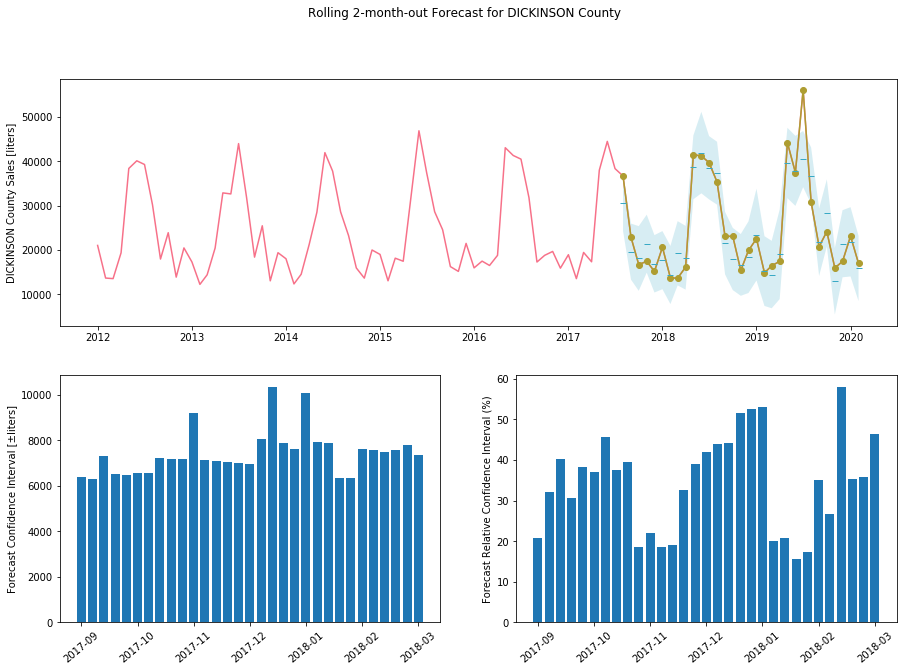

In [52]:
prediction_county = forecast_county(df_county)
show_plots(df_county, prediction_county, 'DICKINSON')